**OPENAI ASSISTANT API WITH FILE SEARCH**

This notebook demonstrates how to utilize OpenAI’s Assistant API with the File Search feature to create an AI assistant capable of answering user queries using external documents.

Steps Covered:

1. Assistant Creation: Set up a custom assistant with specific instructions and select a model. Enable the File Search tool for document-based queries.

2. File Upload files to Vector Store: Upload files and add them to a Vector Store

3. Thread Creation: Start a conversation thread where the assistant interacts with the user, referencing the uploaded documents.

4. Message Handling: Send user queries within the thread. The assistant uses File Search to find relevant content from the documents.

5. Real-Time Interaction: The assistant responds by referencing document content, providing accurate answers with citations for transparency.

**Create Vector Store**

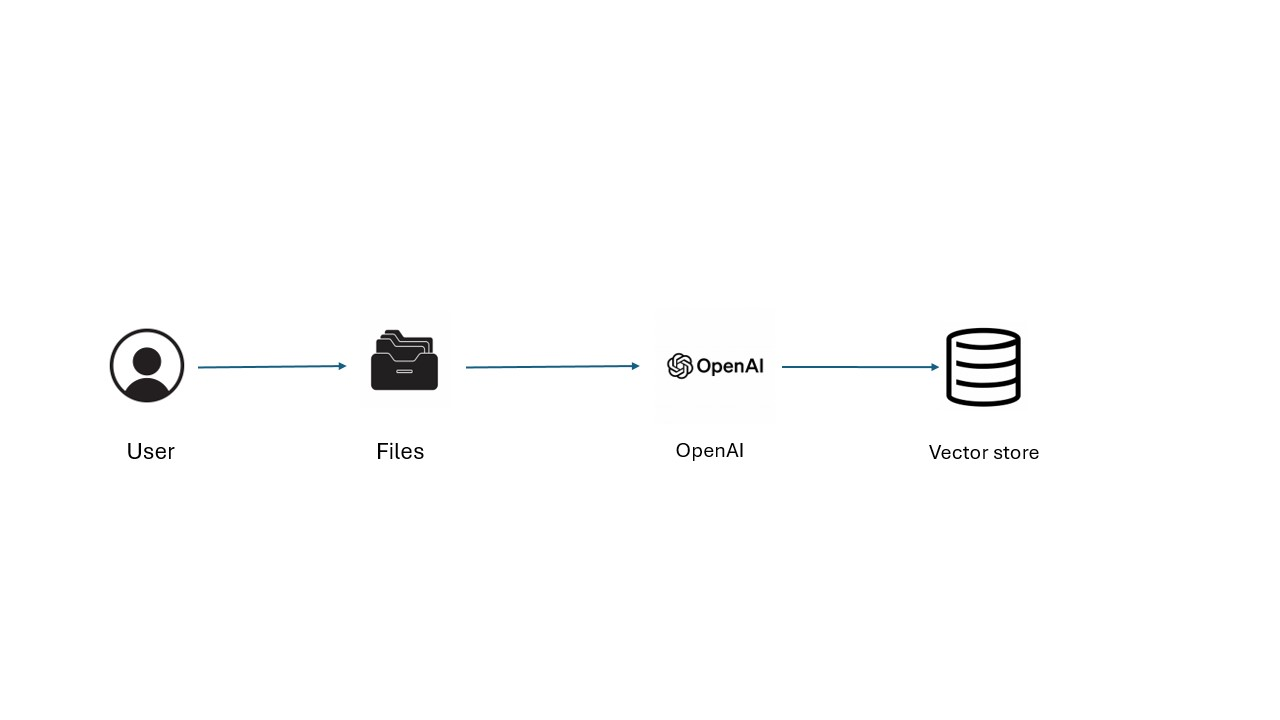

**WorkFlow**

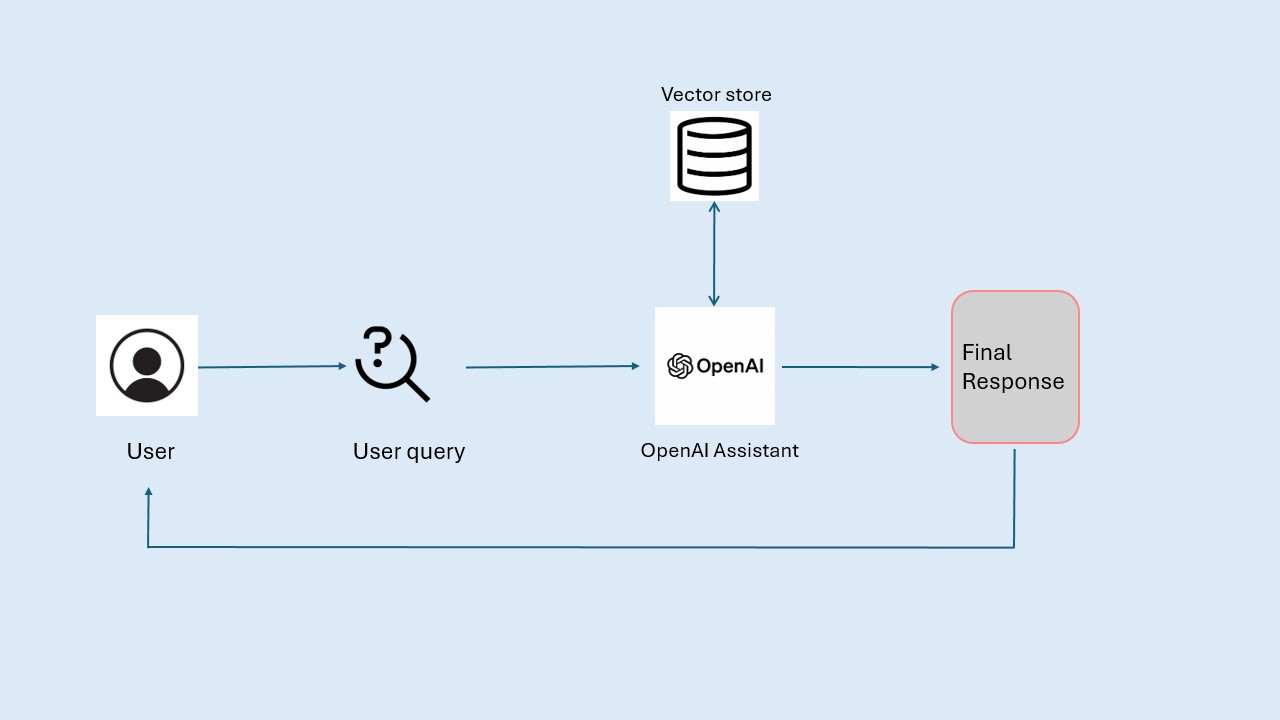

In [ ]:
!pip install openai --upgrade
!pip install load_dotenv --upgrade

In [ ]:
# Set up your environment variables for the Azure OpenAI endpoint and API key.
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
load_dotenv("azureopenai.env")

True

In [ ]:
# Create a new Assistant with File Search Enabled

import os  # Import the os module to interact with environment variables
from openai import AzureOpenAI  # Import the AzureOpenAI class from the openai library to interface with Azure OpenAI

# Initialize the Azure OpenAI client with environment variables for the endpoint, API key, and API version
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),  # Retrieve the Azure OpenAI endpoint from environment variables
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),          # Retrieve the API key from environment variables for authentication
    api_version="2024-05-01-preview"                    # Specify the API version to ensure compatibility with the latest features
)

# Create a new assistant instance on Azure OpenAI with specific configuration
assistant = client.beta.assistants.create(
  name="Financial Analyst Assistant",  # Set the assistant's name to "Financial Analyst Assistant"
  instructions="You are an expert financial analyst. Use your knowledge base to answer questions.",  # Provide detailed instructions for the assistant’s role and domain expertise
  model="gpt-4o-std",  # Specify the model version to be used by the assistant
  tools=[{"type": "file_search"}],  # Enable the "file_search" tool, allowing the assistant to perform searches on uploaded files
)
print(assistant.id)

asst_2v7TyOgxURH3NT7IEB9sg4Rs


In [ ]:
# Upload files and add them to a Vector Store

# Create a vector store caled "Property Sales"
vector_store = client.beta.vector_stores.create(name="Property Sales")

# Ready the files for upload to OpenAI
# Open each file in binary read mode and store file objects in a list for uploading
file_paths = ["real_estate.pdf"]
file_streams = [open(path, "rb") for path in file_paths]

# Upload the files to the vector store
# Use the upload and poll SDK helper to upload the files, add them to the vector store,
# and poll the status of the file batch for completion.
file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
  vector_store_id=vector_store.id, files=file_streams
)

# Print the final status of the file batch to verify if the upload is complete and to check for any issues
print(file_batch.status)

# Display the count of successfully uploaded files, failed uploads, or files in progress
print(file_batch.file_counts)
print(vector_store.id)

completed
FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1)
vs_QHfbvfplm6feijZCOPu5044k


In [ ]:
# Update the assistant to use the new Vector Store

# Update the assistant to use the new Vector Store
assistant = client.beta.assistants.update(
  assistant_id=assistant.id,
  tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
)

In [ ]:
# Upload File and Create a Thread for User Interaction with the Assistant

# Upload the file (e.g., "rs.pdf") needed for the assistant to reference when answering the question
message_file = client.files.create(
    file=open("real_estate.pdf", "rb"),    # Open the file in binary mode to upload it
    purpose="assistants"          # Specify the purpose as "assistants" so the assistant can use it
)

# Create a new thread once, outside the loop, to be reused for all questions
# Create a thread and attach the uploaded file to the initial message
thread = client.beta.threads.create(
    messages=[  # The messages to include in the thread (in this case, just one introductory message)
        {
            "role": "user",  # Specify that the message is from the user
            "content": "hi",  # Initial greeting message content
            "attachments": [  # Attachments to the message, including the file uploaded earlier
                {
                    "file_id": message_file.id,  # Attach the file by its ID
                    "tools": [{"type": "file_search"}]  # Specify the tool that the assistant will use (file search in this case)
                }
            ],
        }
    ]
)

# Main loop to handle continuous questions until the user types "end"
while True:
    # Prompt the user for input
    user_question = input("Enter your question (or type 'end' to stop): ")

    # Exit the loop if the user types "end"
    if user_question.lower() == "end":
        break

    # Send the user's new question in the same thread
    # This adds a new message to the existing thread
    message = client.beta.threads.messages.create(
        thread_id=thread.id,  # The ID of the thread to send the message to
        role="user",  # Specify that the message is from the user
        content=user_question  # The user's input as the content of the message
    )

    # Use the create_and_poll SDK helper to create a run and poll its status
    run = client.beta.threads.runs.create_and_poll(
        thread_id=thread.id,  # The ID of the thread to link the response to
        assistant_id=assistant.id,  # The assistant ID, used to identify which assistant is responding
        instructions="Please address the user as Kshitij Joy."  # Custom instructions for the assistant
    )

    # Fetch the messages generated during the run
    messages = list(client.beta.threads.messages.list(thread_id=thread.id, run_id=run.id))

    # Process the response from the assistant
    if messages and len(messages) > 0:
        # Get the first message from the assistant
        message_content = messages[0].content[0].text
        annotations = message_content.annotations
        citations = []

        # Format the message and handle citations if present
        for index, annotation in enumerate(annotations):
            message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
            if file_citation := getattr(annotation, "file_citation", None):
                cited_file = client.files.retrieve(file_citation.file_id)
                citations.append(f"[{index}] {cited_file.filename}")

        # Print the assistant's response and citations
        print(f"Assistant > {message_content.value}")
        if citations:
            print("\n".join(citations))
    else:
        print("No response received from the assistant.")




Enter your question (or type 'end' to stop): Hello
Assistant > Hello Kshitij Joy! How can I assist you today?
Enter your question (or type 'end' to stop): what is the uploaded file all about
Assistant > The uploaded file appears to be a list of real estate properties with various details, including:

- Property ID
- Location
- City
- State
- Property Type
- Price
- Number of Bedrooms
- Number of Bathrooms
- Square Feet
- Year Built
- Status (e.g., Sold, Pending, For Sale)
- Days on Market
- Real Estate Agent

The document provides detailed information on multiple real estate properties across different cities and states[0][1][2]. 

Is there anything specific you would like to know or any particular information you need from this file, Kshitij Joy?
[0] real_estate.pdf
[1] real_estate.pdf
[2] real_estate.pdf
Enter your question (or type 'end' to stop): give me names of agents and properties sold by them
Assistant > Here are the names of agents and the properties that have been sold by th